
BloomTech Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

## Assignment

Complete these tasks for your assignment/project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. Review requirements for your portfolio project on Canvas, and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [2]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling

In [3]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
import numpy as np

In [75]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/My Drive/ML Projects

/content/gdrive/My Drive/ML Projects


In [7]:
!ls

student-mat.csv


In [37]:
df = pd.read_csv('student-mat.csv', sep = ';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [9]:
df.shape

(395, 33)

Target = G3 (third period grade)

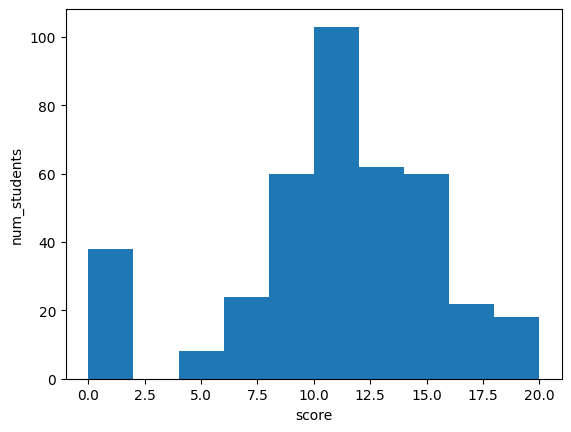

In [10]:
plt.hist(df['G3'])
plt.xlabel('score')
plt.ylabel('num_students')
plt.show()

In [38]:
df = df[df['G3'] != 0]

In [39]:
df['G3'].value_counts().sort_index(ascending = False)

20     1
19     5
18    12
17     6
16    16
15    33
14    27
13    31
12    31
11    47
10    56
9     28
8     32
7      9
6     15
5      7
4      1
Name: G3, dtype: int64

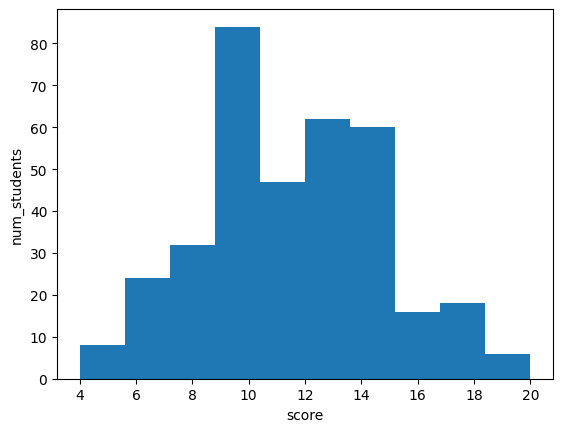

In [40]:
plt.hist(df['G3'])
plt.xlabel('score')
plt.ylabel('num_students')
plt.show()

After dropping '0' values indicating that the student has not yet recieved a score for g3, the target column is fairly normally distributed

I will use MAE to create a linear and ridge regression models

I will use a random split and delete the rows with 0 as a value in g3

In [41]:
# CREATING BINARY COLUMN FOR FAM SIZE
df['famsize'].describe()
df['big_family'] = (df['famsize'] == 'GT3').astype(int)
df['big_family'].value_counts(), df['famsize'].value_counts()
# this can be done with the categorical encoder but I jsut wanted to see
df.drop(columns = 'famsize',inplace = True)
df.head()

,school,sex,age,address,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,big_family
0,GP,F,18,U,A,4,4,at_home,teacher,course,...,3,4,1,1,3,6,5,6,6,1
1,GP,F,17,U,T,1,1,at_home,other,course,...,3,3,1,1,3,4,5,5,6,1
2,GP,F,15,U,T,1,1,at_home,other,other,...,3,2,2,3,3,10,7,8,10,0
3,GP,F,15,U,T,4,2,health,services,home,...,2,2,1,1,5,2,15,14,15,1
4,GP,F,16,U,T,3,3,other,other,home,...,3,2,1,2,5,4,6,10,10,1


G1 and G2 would provide strong indicators of g3, so I will remove those

In [42]:
# df.drop(columns = ['G2','G1'], inplace = True)
# df.head()

,school,sex,age,address,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,big_family
0,GP,F,18,U,A,4,4,at_home,teacher,course,...,no,4,3,4,1,1,3,6,6,1
1,GP,F,17,U,T,1,1,at_home,other,course,...,no,5,3,3,1,1,3,4,6,1
2,GP,F,15,U,T,1,1,at_home,other,other,...,no,4,3,2,2,3,3,10,10,0
3,GP,F,15,U,T,4,2,health,services,home,...,yes,3,2,2,1,1,5,2,15,1
4,GP,F,16,U,T,3,3,other,other,home,...,no,4,3,2,1,2,5,4,10,1


In [43]:
df['higher'].describe()

count     357
unique      2
top       yes
freq      343
Name: higher, dtype: object

In [17]:
    # cutoff = 50
    # drop_cols = [col for col in df.select_dtypes('object').columns
    #              if df[col].nunique() > cutoff]
    # df.drop(columns=drop_cols, inplace=True)

In [44]:
df['motivated_student'] = ((df['higher'] == 'yes') & (df['absences'] > 20)).astype(int)

In [45]:
df['parent_at_home'] = ((df['Mjob'] == 'at_home') | (df['Fjob'] == 'at_home')).astype(int)
df['parent_at_home'].value_counts()

0    296
1     61
Name: parent_at_home, dtype: int64

In [46]:
df['first_gen_student'] = ((df['Medu'] < 3) & (df['Fedu'] < 3)).astype(int)
df['first_gen_student'].value_counts()

0    243
1    114
Name: first_gen_student, dtype: int64

In [47]:
target = 'G3'
X = df.drop(columns = target)
y = df[target]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# X.shape, X_train.shape, X_val.shape, X_test.shape

In [60]:
baseline_mae = y_train.mean()
y_base_pred = [baseline_mae] * len(y_train)
print('Baseline Train MAE:', mean_absolute_error(y_train, y_base_pred))
print('Baseline Val MAE:', mean_absolute_error(y_val, [baseline_mae] * len(y_val)))

Baseline Train MAE: 2.682947508667808
Baseline Val MAE: 2.382253425816275


In [104]:
model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                     'Mjob', 'Fjob', 'reason', 'guardian',
                                     'schoolsup', 'famsup', 'paid',
                                     'activities', 'nursery', 'higher',
                                     'internet', 'romantic'])),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [109]:
param_grid1 =  {
  'ridge__alpha':range(90,150,1),
}
model_r_tune = GridSearchCV(
    model,
    param_grid1,
    n_jobs = -1,
    verbose = 1,
    cv= 3
    )
model_r_tune.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['school', 'sex',
                                                            'address',
                                                            'Pstatus', 'Mjob',
                                                            'Fjob', 'reason',
                                                            'guardian',
                                                            'schoolsup',
                                                            'famsup', 'paid',
                                                            'activities',
                                                            'nursery', 'higher',
                                                            'internet',
                                                            'romantic'])),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1, param_grid={'ridge__alpha': range(90, 150)}, verbose=1)

In [116]:
print(model_r_tune.best_params_)
print(model_r_tune.best_score_)
print(model_r_tune.best_estimator_)

model_r_tuned = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    Ridge(alpha = 145)
)
model_r_tuned.fit(X_train,y_train)

{'ridge__alpha': 145}
0.16048174392956846
Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                     'Mjob', 'Fjob', 'reason', 'guardian',
                                     'schoolsup', 'famsup', 'paid',
                                     'activities', 'nursery', 'higher',
                                     'internet', 'romantic'])),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=145))])


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                     'Mjob', 'Fjob', 'reason', 'guardian',
                                     'schoolsup', 'famsup', 'paid',
                                     'activities', 'nursery', 'higher',
                                     'internet', 'romantic'])),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=145))])

In [117]:
print('Train MAE:', mean_absolute_error(y_train, model_r_tuned.predict(X_train)))
print('Val MAE:', mean_absolute_error(y_val, model_r_tuned.predict(X_val)))
print('Validation R^2:', model_r_tuned.score(X_val, y_val))

Train MAE: 2.2174145682717654
Val MAE: 1.9725928777850046
Validation R^2: 0.20462063417500853


In [61]:
y_val_preds = model.predict(X_val)
print('Train MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Val MAE:', mean_absolute_error(y_val, y_val_preds))
print('Validation R^2:', model.score(X_val, y_val))

Train MAE: 2.1038760880315834
Val MAE: 1.9155263544817749
Validation R^2: 0.16136233888351914


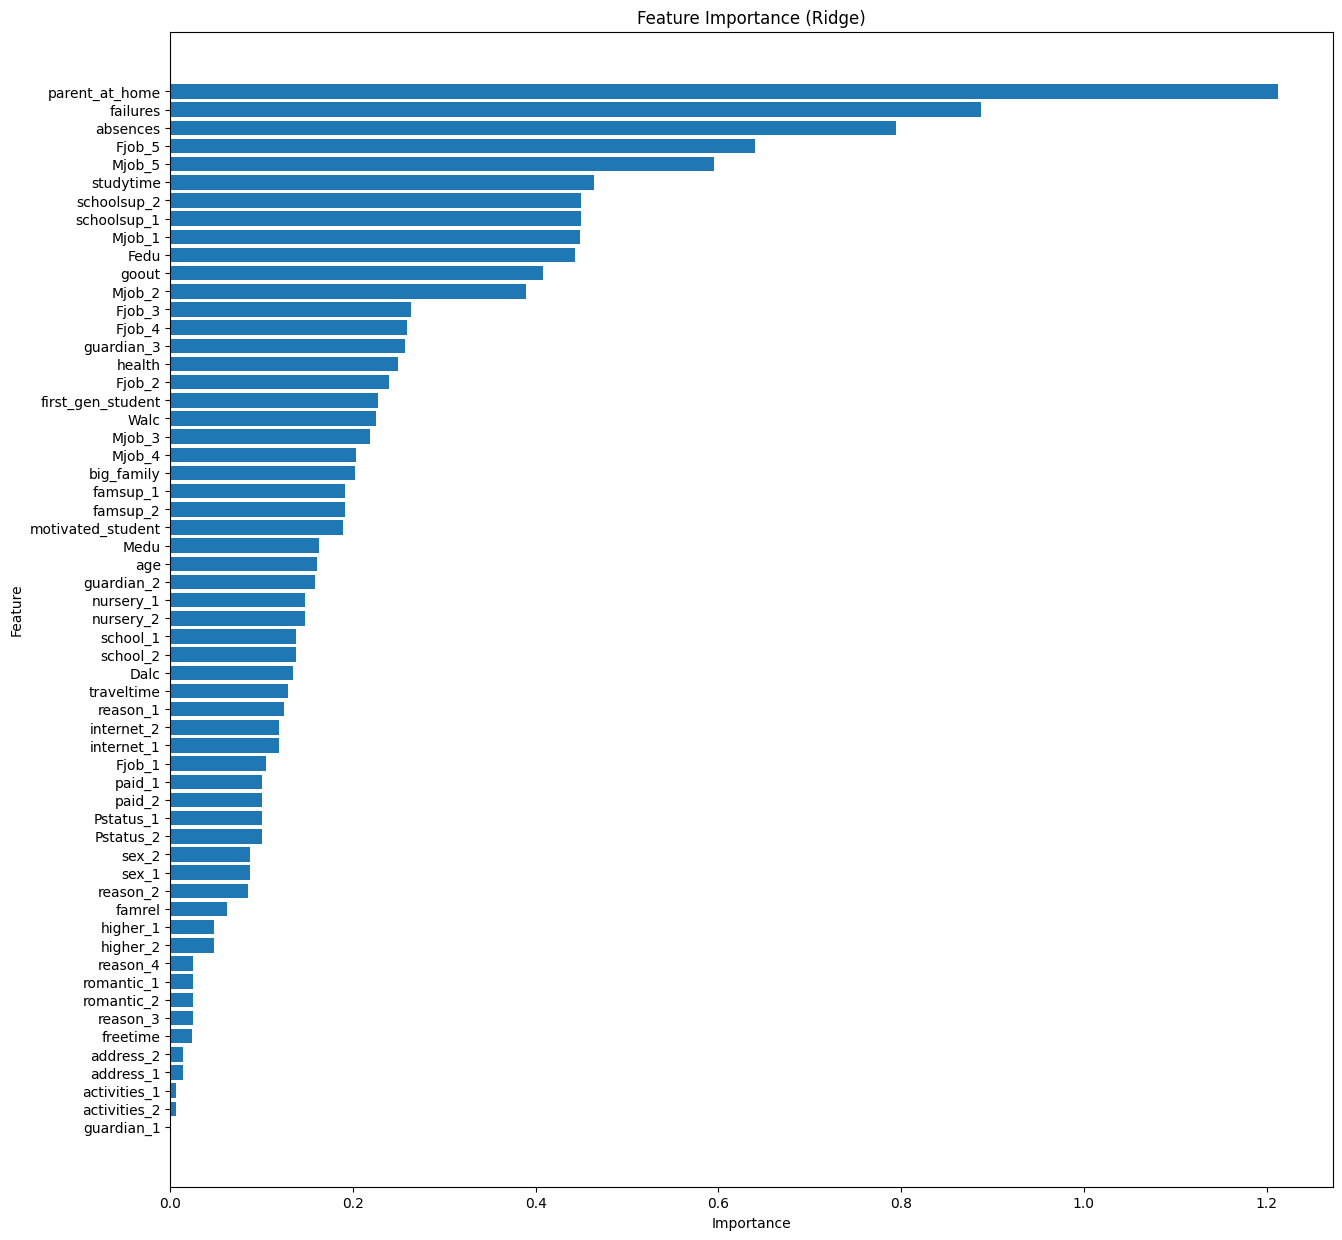

In [53]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names_out()
coefficients = np.abs(coefficients)

# Create a pandas DataFrame for easier manipulation
df = pd.DataFrame({'Feature': features, 'Importance': coefficients})

# Sort the DataFrame by importance
df = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 15))
plt.barh(df['Feature'], df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Ridge)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [81]:
model_perm = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(random_state = 42, n_jobs = -1)
)
model_perm.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                      'Mjob', 'Fjob', 'reason', 'guardian',
                                      'schoolsup', 'famsup', 'paid',
                                      'activities', 'nursery', 'higher',
                                      'internet', 'romantic'],
                                mapping=[{'col': 'school',
                                          'data_type': dtype('O'),
                                          'mapping': GP     1
MS     2
NaN   -2
dtype: int64},
                                         {'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype:...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

<Axes: >

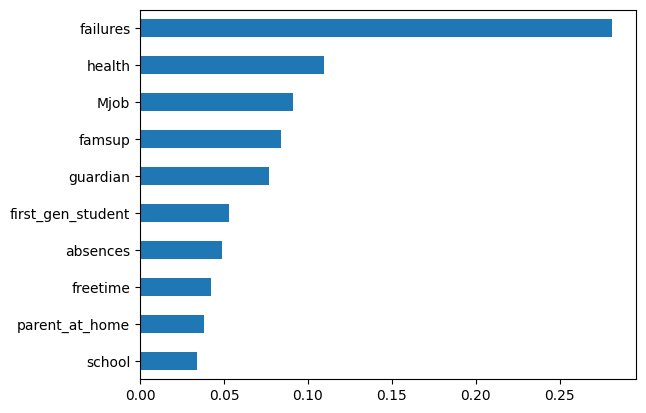

In [58]:
perm_imp = permutation_importance(model_perm, X_val, y_val, random_state = 42)

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

df_perm['imp_mean'].tail(10).plot(kind='barh')

In [63]:
  print('Training MAE:', mean_absolute_error(y_train, model_perm.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model_perm.predict(X_val)))
  print('Validation R^2:', model_perm.score(X_val, y_val))

Training MAE: 0.0008960929826075929
Validation MAE: 2.341553905735845
Validation R^2: -0.17829540676168065


In [ ]:
  print('Training MAE:', mean_absolute_error(y_train, model_perm.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model_perm.predict(X_val)))
  print('Validation R^2:', model_perm.score(X_val, y_val))

In [71]:
param_grid =  {
  'xgbregressor__max_depth':range(5,40,5),
  'xgbregressor__n_estimators':range(25,125,25),
  'xgbregressor__scale_pos_weight':[1,1.5,2],
  'xgbregressor__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

In [100]:
from sklearn.model_selection import RandomizedSearchCV
model_xgb_tune = GridSearchCV(
    model_perm,
    param_grid,
    n_jobs = -1,
    verbose = 1,
    cv= 2
    )
model_xgb_tune.fit(X_train,y_train)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['school', 'sex',
                                                             'address',
                                                             'Pstatus', 'Mjob',
                                                             'Fjob', 'reason',
                                                             'guardian',
                                                             'schoolsup',
                                                             'famsup', 'paid',
                                                             'activities',
                                                             'nursery',
                                                             'higher',
                                                             'internet',
                                                             'romantic'],
                                                       mapping=[{'col': 'school',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': GP     1
MS     2
NaN   -2
dtype: int64},
                                                                {'col': 'sex',
                                                                 'data_type': dtype('O...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 0.6],
                         'xgbregressor__max_depth': range(30, 80, 10),
                         'xgbregressor__n_estimators': range(25, 125, 25),
                         'xgbregressor__scale_pos_weight': [1, 1.5, 2]},
             verbose=1)

In [101]:
print(model_xgb_tune.best_params_)
print(model_xgb_tune.best_score_)
print(model_xgb_tune.best_estimator_)

{'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 30, 'xgbregressor__n_estimators': 25, 'xgbregressor__scale_pos_weight': 1}
-0.026545615987325577
Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                      'Mjob', 'Fjob', 'reason', 'guardian',
                                      'schoolsup', 'famsup', 'paid',
                                      'activities', 'nursery', 'higher',
                                      'internet', 'romantic'],
                                mapping=[{'col': 'school',
                                          'data_type': dtype('O'),
                                          'mapping': GP     1
MS     2
NaN   -2
dtype: int64},
                                         {'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype:...
                              feature_types=None, gamm

In [135]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(
       n_jobs = -1,
       random_state = 42,
       scale_pos_weight = 1,
       n_estimators = 5,
       max_depth = 30,
       learning_rate = .2,
    )
)
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school', 'sex', 'address', 'Pstatus',
                                      'Mjob', 'Fjob', 'reason', 'guardian',
                                      'schoolsup', 'famsup', 'paid',
                                      'activities', 'nursery', 'higher',
                                      'internet', 'romantic'],
                                mapping=[{'col': 'school',
                                          'data_type': dtype('O'),
                                          'mapping': GP     1
MS     2
NaN   -2
dtype: int64},
                                         {'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype:...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=30, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=5, n_jobs=-1, num_parallel_tree=None,
                              random_state=42, ...))])

In [136]:
  print('Training MAE:', mean_absolute_error(y_train, model_xgb.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model_xgb.predict(X_val)))
  print('Validation R^2:', model_xgb.score(X_val, y_val))
  print()
  print('Training MAE:', mean_absolute_error(y_train, model_r_tuned.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model_r_tuned.predict(X_val)))
  print('Validation R^2:', model_r_tuned.score(X_val, y_val))
  print()
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))

Training MAE: 1.1956671462448654
Validation MAE: 2.089147609213124
Validation R^2: 0.01790474602376546

Training MAE: 2.2174145682717654
Validation MAE: 1.9725928777850046
Validation R^2: 0.20462063417500853

Training MAE: 2.1038760880315834
Validation MAE: 1.9155263544817749
Validation R^2: 0.16136233888351914
